<a href="https://colab.research.google.com/github/TomBaran501/BDD_Boulangerie/blob/main/projetDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Récupération des données depuis notre git

In [ ]:
!git clone https://github.com/TomBaran501/BDD_Boulangerie.git
path = "./BDD_Boulangerie/"

Cloning into 'BDD_Boulangerie'...
remote: Enumerating objects: 1436, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1436 (delta 3), reused 18 (delta 2), pack-reused 1411
Receiving objects: 100% (1436/1436), 516.41 MiB | 15.27 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (1455/1455), done.


Tous les trucs à charger

In [ ]:
import os
import shutil
import glob
import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
import tensorflow.keras.layers as layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns



Une fois les données téléchargées localement, on peut maintenant charger les images et les labels.

In [ ]:


def load_data(data_path, classes, dataset='train', image_size=128):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)

    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))

    current_index = 0

    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)

        # Chargement des images,
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Redimensionnement de l'image et écriture dans la variable de retour x
                img = img.resize((image_size,image_size))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index] = idx_class
                current_index += 1

    return x, y

Création des labels et des données d'apprentissage, de validation et des test. La taille des images est de 128*128.


In [ ]:
labels = ['baguette', 'croissant', 'painAuChocolat']

x_train, y_train = load_data(path, labels, dataset='train', image_size=128)
print(x_train.shape, y_train.shape)

x_val, y_val = load_data(path, labels, dataset='validation', image_size=128)
print(x_val.shape, y_val.shape)

x_test, y_test = load_data(path, labels, dataset='test', image_size=128)
print(x_test.shape, y_test.shape)

#Normalisation
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

KeyboardInterrupt: 

Vous pouvez utiliser le bloc suivant pour afficher quelques-unes de vos images, et ainsi vérifier que tout s'est bien passé.

<ipython-input-5-a0fa1fc7bed3>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(labels[int(y_train[shuffle_indices[i]])])


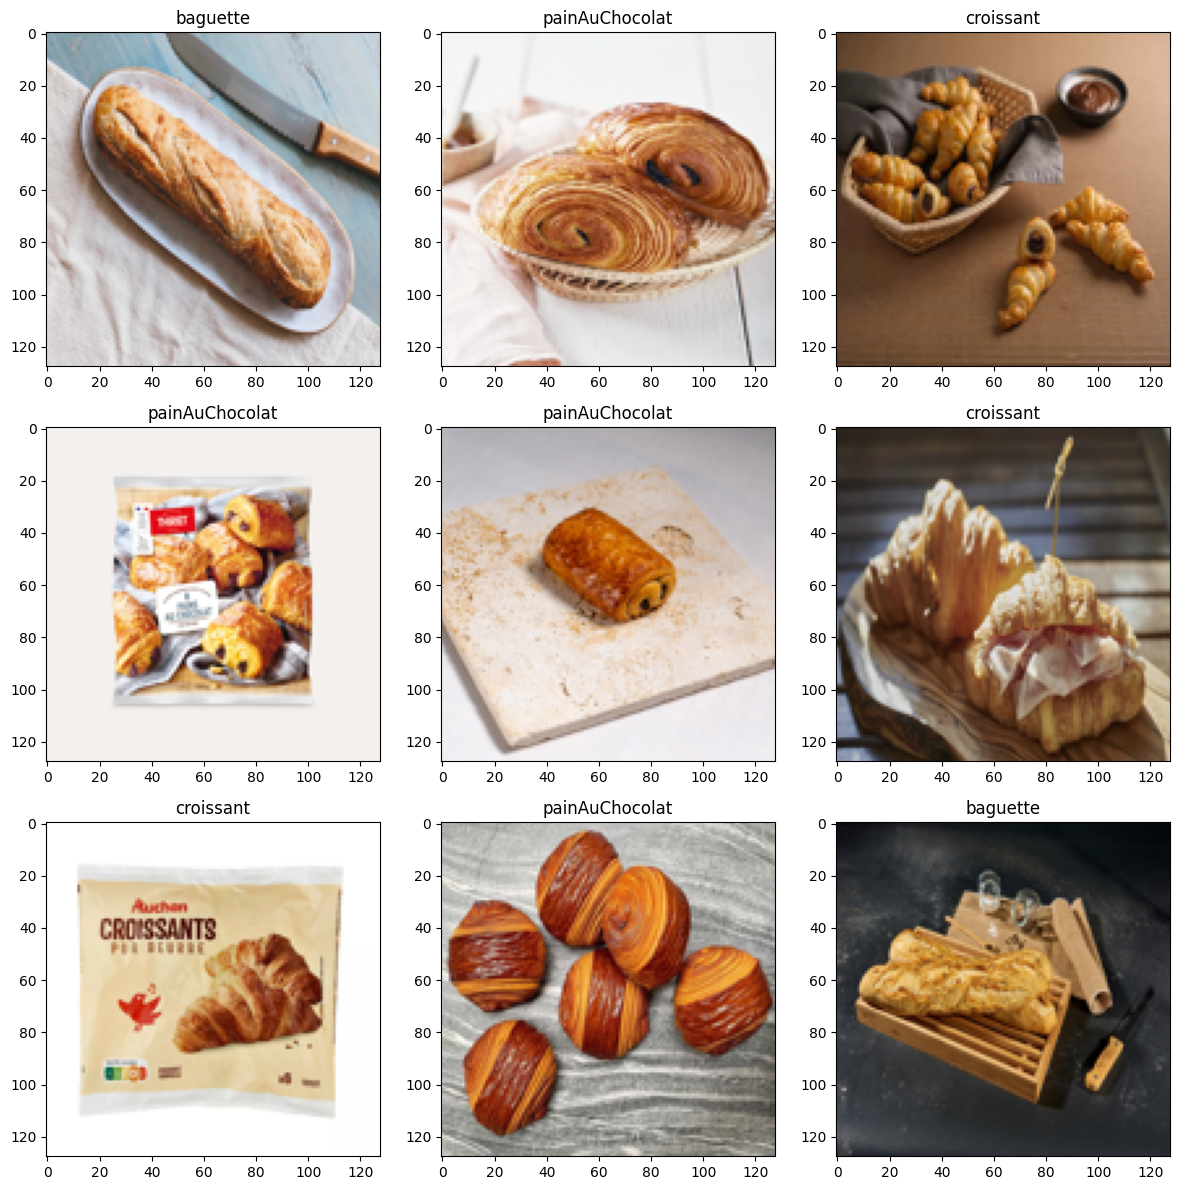

In [ ]:


plt.figure(figsize=(12, 12))
shuffle_indices = np.random.permutation(900)
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(image)

plt.tight_layout()
plt.show()


Code pour faire de l'augmentation de données ?

Création du modèle

In [ ]:

model = Sequential()

model.add(Conv2D(32,(3,3),activation = "relu",input_shape=(128,128,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3), activation = "relu"))
model.add(MaxPooling2D())

model.add(Conv2D(96,(3,3) ,activation = "relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3), activation = "relu"))
model.add(MaxPooling2D())
# ...
model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense
model.add(Dense(512,activation ="relu",input_dim = (128,128,3)))  # Couche dense, à 512 neurones
model.add(Dense(3, "softmax"))   # Couche de sortie

model.summary()

# AJOUTER EGALEMENT LA FONCTION DE COUT
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(x_train, y_train, batch_size=10,
                    validation_data=(x_val, y_val),
                    epochs=50,
                    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 96)        0

Définition de la fonction permettant d'afficher précision du modèle et de voir le surapprentissage.

A ce stade, on a beaucoup, beaucoup de surapprentissage.

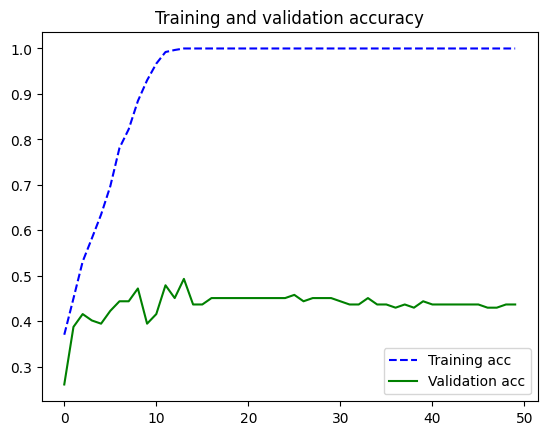

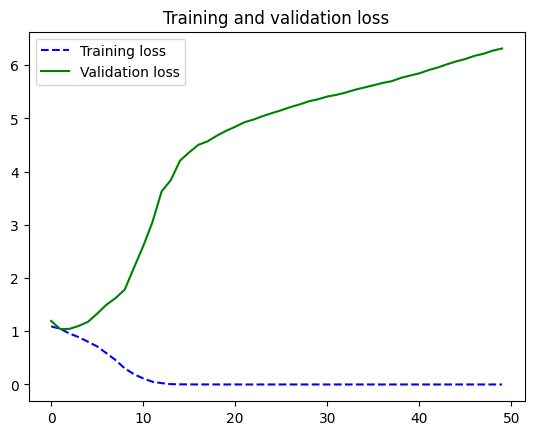

In [ ]:
plot_training_analysis2()

La précision du modèle est assez faible ~50% ce qui est assez peu (au même stade c'était ~70% pour le tp3) et beaucoup de surapprentissage (en même temps la base d'apprentissage est d'environ 1200 images, ce qui est peu). Pour le coup dans le TP3, il y a du suraprentissage (2000 images) mais ce n'est pas aussi excessif...


In [ ]:

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    )


train_datagen2 = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


<ipython-input-20-a2b14e30d3ff>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(labels[int(example_y[i])])


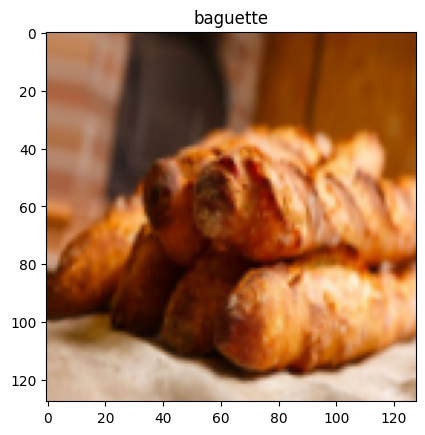

In [ ]:
example_x, example_y = train_datagen.flow(x_train, y_train, batch_size=1).next()
for i in range(0,1):
    plt.imshow(example_x[i])
    plt.title(labels[int(example_y[i])])
    plt.show()

In [ ]:

model = Sequential()

model.add(Conv2D(32,(3,3),activation = "relu",input_shape=(128,128,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3), activation = "relu"))
model.add(MaxPooling2D())

model.add(Conv2D(96,(3,3) ,activation = "relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3), activation = "relu"))
model.add(MaxPooling2D())
# ...
model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense
model.add(Dense(512,activation ="relu",input_dim = (128,128,3)))  # Couche dense, à 512 neurones
model.add(Dense(3, "softmax"))   # Couche de sortie

model.summary()

# AJOUTER EGALEMENT LA FONCTION DE COUT
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_datagen2.flow(x_train, y_train, batch_size=10),
                    validation_data=(x_val, y_val),
                    epochs=50,
                    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 96)        55392     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 96)       

In [ ]:
def plot_training_analysis2():
  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

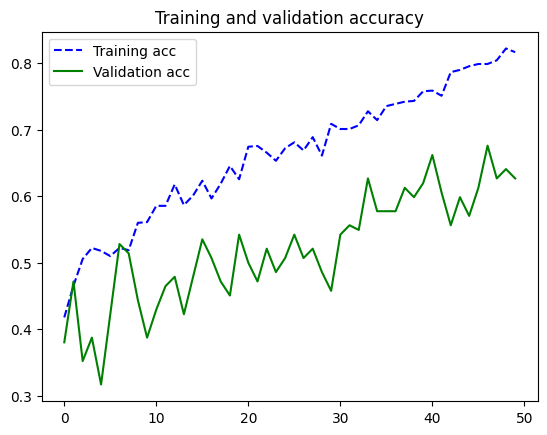

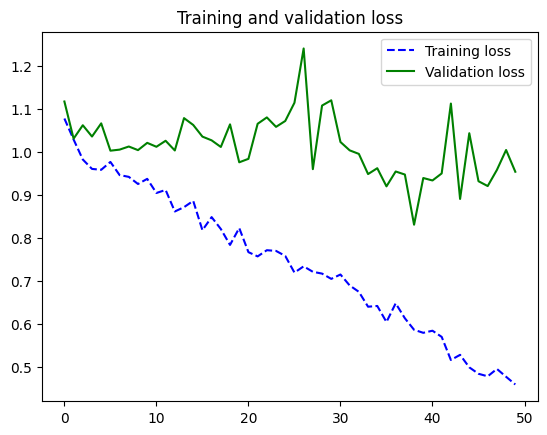

In [ ]:
plot_training_analysis2()

Meilleure précision et surpapprentissage plus faible. On est quand même sur des valeurs élevées mais dans une échelle proche. C'est beaucoup mieux que certains résulats que j'avais avant où je dépaissais les 6 de perte...


Transfert learning


In [ ]:

IMAGE_SIZE = 128
conv_base = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
print(x_train.shape)
train_features = conv_base.predict(x_train)
print(train_features.shape)
train_features = np.reshape(train_features,(train_features.shape[0],4*4*512))

val_features = conv_base.predict(x_val)
val_features = np.reshape(val_features,(val_features.shape[0],4*4*512))

print(y_train.shape
      )

(900, 128, 128, 3)
29/29 [==============================] - 6s 85ms/step
(900, 4, 4, 512)
5/5 [==============================] - 2s 498ms/step
(900, 1)


In [ ]:

model = Sequential()

model.add(Dense(256,activation ="relu",input_dim = 8192))  # Couche dense, à 512 neurones
model.add(Dense(3, "softmax"))   # Couche de sortie

model.summary()

# AJOUTER EGALEMENT LA FONCTION DE COUT
model.compile(optimizer=optimizers.Adam(lr=3e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

# COMPLETER AVEC LES TENSEURS SUR LESQUELS EFFECTUER L'APPRENTISSAGE
history = model.fit(train_features, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_data=(val_features, y_val))



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 2098179 (8.00 MB)
Trainable params: 2098179 (8.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
57/57 [==============================] - 1s 6ms/step - loss: 0.8651 - sparse_categorical_accuracy: 0.6756 - val_loss: 0.8878 - val_sparse_categorical_accuracy: 0.5986
Epoch 2/50
57/57 [==============================] - 0s 4ms/step - loss: 0.2486 - sparse_categorical_accuracy: 0.9189 - val_loss: 0.9020 - val_sparse_categorical_accuracy: 0.6127
Epoch 3/50
57/57 [==============================] - 0s 4ms/step - loss: 0.1291 - sparse_categorical_accuracy: 0.9689 - val_loss: 0.9047 - val_sparse_categorical_accuracy: 0.6690
Epoch 4/50
57/57 [==============================] - 0s 4ms/step - loss: 0.0604 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.9704 - val_sparse_categorical_accuracy: 0.6690
Epoch 5/50
57/57 [==============================] - 0s 4ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.9967 - val_loss: 1.2142 - val_sparse_categorical_accuracy: 0.6549
Epoch 6/50
57/57 [==============================] - 0s 3ms/step - loss: 0.0250 - sparse_categorical_accuracy: 

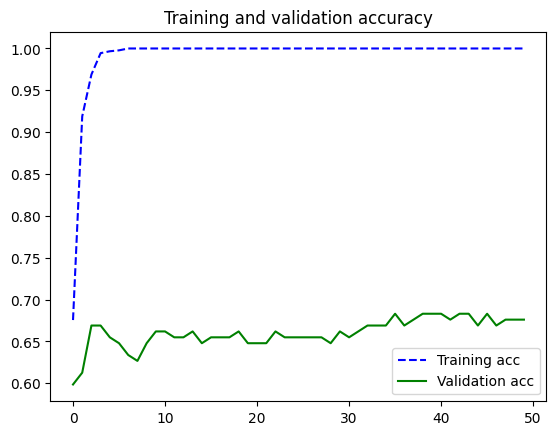

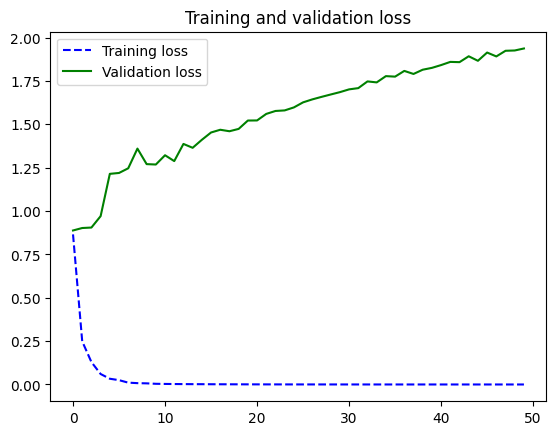

In [ ]:
plot_training_analysis2()

In [ ]:

model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 16812867 (64.14 MB)
Trainable params: 16812867 (64.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
conv_base.trainable = False
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 16812867 (64.14 MB)
Trainable params: 2098179 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_datagen.flow(x_train, y_train, batch_size=10),
                    validation_data=(x_val, y_val),
                    epochs=50,
                    )

Epoch 1/50
90/90 [==============================] - 8s 46ms/step - loss: 0.7345 - sparse_categorical_accuracy: 0.6922 - val_loss: 0.8468 - val_sparse_categorical_accuracy: 0.6690
Epoch 2/50
90/90 [==============================] - 5s 60ms/step - loss: 0.5034 - sparse_categorical_accuracy: 0.7956 - val_loss: 0.8811 - val_sparse_categorical_accuracy: 0.6479
Epoch 3/50
90/90 [==============================] - 4s 44ms/step - loss: 0.3926 - sparse_categorical_accuracy: 0.8322 - val_loss: 0.8282 - val_sparse_categorical_accuracy: 0.7113
Epoch 4/50
90/90 [==============================] - 4s 46ms/step - loss: 0.3077 - sparse_categorical_accuracy: 0.8789 - val_loss: 1.2829 - val_sparse_categorical_accuracy: 0.6268
Epoch 5/50
90/90 [==============================] - 6s 63ms/step - loss: 0.3131 - sparse_categorical_accuracy: 0.8800 - val_loss: 0.9177 - val_sparse_categorical_accuracy: 0.6761
Epoch 6/50
90/90 [==============================] - 4s 45ms/step - loss: 0.2693 - sparse_categorical_accu

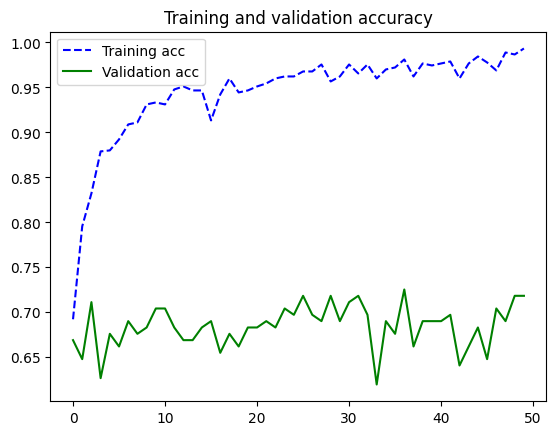

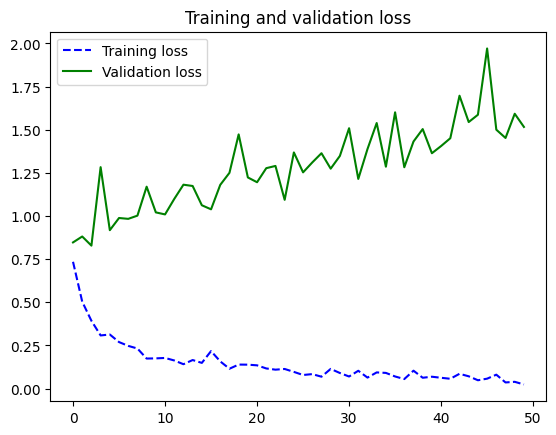

In [ ]:
plot_training_analysis2()

Go faire du fine-tuning


In [ ]:
conv_base.trainable = True
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                                 
Total params: 16812867 (64.14 MB)
Trainable params: 16812867 (64.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5), # Taux d'apprentissage réduit pour ne pas tout casser, ni risquer le sur-apprentissage !
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_datagen.flow(x_train, y_train, batch_size=10),
                    validation_data=(x_val, y_val),
                    epochs=50,
                    )

Epoch 1/50
90/90 [==============================] - 15s 71ms/step - loss: 0.1320 - sparse_categorical_accuracy: 0.9544 - val_loss: 1.5837 - val_sparse_categorical_accuracy: 0.6549
Epoch 2/50
90/90 [==============================] - 7s 77ms/step - loss: 0.1034 - sparse_categorical_accuracy: 0.9667 - val_loss: 1.6346 - val_sparse_categorical_accuracy: 0.6690
Epoch 3/50
90/90 [==============================] - 6s 69ms/step - loss: 0.1133 - sparse_categorical_accuracy: 0.9600 - val_loss: 1.4541 - val_sparse_categorical_accuracy: 0.7113
Epoch 4/50
90/90 [==============================] - 7s 79ms/step - loss: 0.0580 - sparse_categorical_accuracy: 0.9778 - val_loss: 1.4302 - val_sparse_categorical_accuracy: 0.7183
Epoch 5/50
90/90 [==============================] - 6s 71ms/step - loss: 0.0606 - sparse_categorical_accuracy: 0.9789 - val_loss: 1.2942 - val_sparse_categorical_accuracy: 0.7183
Epoch 6/50
90/90 [==============================] - 7s 78ms/step - loss: 0.0520 - sparse_categorical_acc

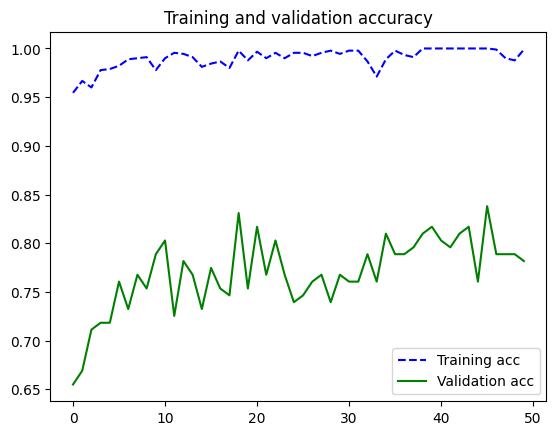

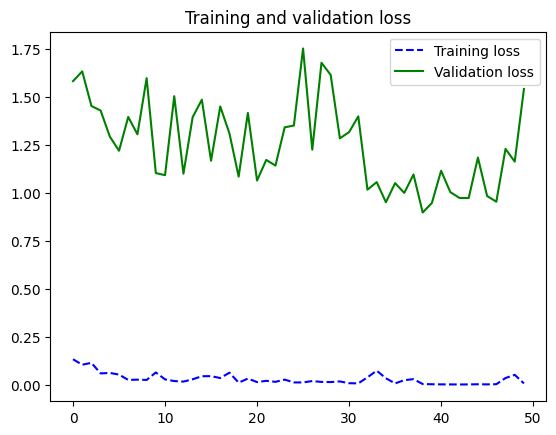

In [ ]:
plot_training_analysis2()

In [ ]:
results = model.evaluate(x_test, y_test)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

5/5 [==============================] - 2s 590ms/step - loss: 0.7543 - sparse_categorical_accuracy: 0.8467
Test Loss: 0.7543480396270752
Test Accuracy: 0.846666693687439


5/5 [==============================] - 1s 68ms/step


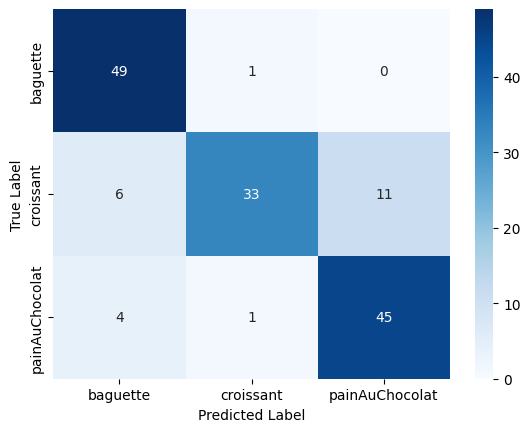

In [ ]:

predictions = model.predict(x_test)
classe_predictions = np.argmax(predictions, axis = 1)

confusion = confusion_matrix(y_test, classe_predictions)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print(classification_report(y_test, classe_predictions, target_names=labels))

                precision    recall  f1-score   support

      baguette       0.83      0.98      0.90        50
     croissant       0.94      0.66      0.78        50
painAuChocolat       0.80      0.90      0.85        50

      accuracy                           0.85       150
     macro avg       0.86      0.85      0.84       150
  weighted avg       0.86      0.85      0.84       150



A l'issue de cet apprentissage, la précision globale est d'environ 84%. C'est un score plutôt bon même si, pour des images à 128*128, on aurait aimé une meilleure précision... On est même au dessus de la précision des données de validation (autour de 80%).

Maintenant, en allant plus dans le détails on se rend compte que notre réseau détécte très bien les baguettes et les pains au chocolat (98% et 90% de recall pour ces deux classes). Le problème principal, qui est la raison qui fait que notre réseau à une précision si faible, vient du fait que le recall du croissant et de seulement 66% : une image de croissant sur 3 n'est pas correctement reconnue. En particulier, elles sont souvent confondues avec des pains au chocolat, ce qui est assez cohérent, les deux viennoiseries ayant une forme similaire. Pour autant notre réseau ne confond pas un pain au chocolat avec un croissant (la présence du point de chocolat dans le pain au chocolat serait suffisant pour le détecter mais pas nécessaire).

Comment améliorer ce point ?


In [ ]:
x_train2, y_train2 = load_data(path, labels, dataset='train', image_size=256)

x_val2, y_val2 = load_data(path, labels, dataset='validation', image_size=256)

x_test2, y_test2 = load_data(path, labels, dataset='test', image_size=256)

#Normalisation
x_train2 = x_train2/255
x_val2 = x_val2/255
x_test2 = x_test2/255

In [ ]:

conv_base2 = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(256, 256, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:

train_features2 = conv_base2.predict(x_train2)
train_features2 = np.reshape(train_features2,(train_features2.shape[0],4*16*512))

val_features2 = conv_base2.predict(x_val2)
val_features2 = np.reshape(val_features2,(val_features2.shape[0],4*16*512))

13/29 [============>.................] - ETA: 7:04

In [ ]:

model = Sequential()

model.add(Dense(256,activation ="relu",input_dim = 4*8192))  # Couche dense, à 512 neurones
model.add(Dense(3, "softmax"))   # Couche de sortie

model.summary()

# AJOUTER EGALEMENT LA FONCTION DE COUT
model.compile(optimizer=optimizers.Adam(lr=3e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

# COMPLETER AVEC LES TENSEURS SUR LESQUELS EFFECTUER L'APPRENTISSAGE
history = model.fit(train_features2, y_train2,
                    epochs=50,
                    batch_size=16,
                    validation_data=(val_features2, y_val2))

model.save("v21.h5")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               8388864   
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 8389635 (32.00 MB)
Trainable params: 8389635 (32.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
57/57 [==============================] - 2s 12ms/step - loss: 1.4990 - sparse_categorical_accuracy: 0.6600 - val_loss: 0.9648 - val_sparse_categorical_accuracy: 0.6620
Epoch 2/50
57/57 [==============================] - 0s 8ms/step - loss: 0.1197 - sparse_categorical_accuracy: 0.9611 - val_loss: 1.3775 - val_sparse_categorical_accuracy: 0.6268
Epoch 3/50
57/57 [==============================] - 0s 8ms/step - loss: 0.0418 - sparse_categorical_accuracy: 0.9878 - val_loss: 1.3610 - val_sparse_categorical_accuracy: 0.6338
Epoch 4/50
57/57 [==============================] - 0s 7ms/step - loss: 0.0176 - sparse_categorical_accuracy: 0.9944 - val_loss: 1.2377 - val_sparse_categorical_accuracy: 0.6338
Epoch 5/50
57/57 [==============================] - 0s 6ms/step - loss: 0.0050 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.1660 - val_sparse_categorical_accuracy: 0.6479
Epoch 6/50
57/57 [==============================] - 0s 6ms/step - loss: 0.0030 - sparse_categorical_accuracy:

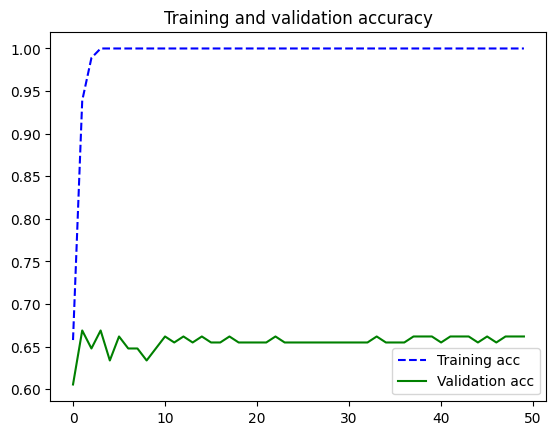

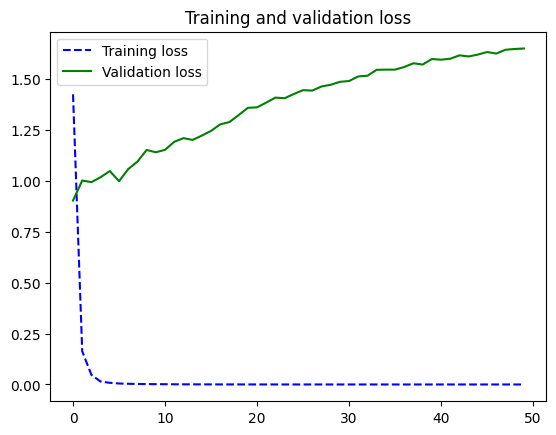

In [ ]:
plot_training_analysis2()

In [ ]:
import tensorflow.keras.layers as layers

model = Sequential()
model.add(conv_base2)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               8388864   
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 23104323 (88.14 MB)
Trainable params: 23104323 (88.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
conv_base2.trainable = False
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               8388864   
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                                 
Total params: 23104323 (88.14 MB)
Trainable params: 8389635 (32.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_datagen2.flow(x_train2, y_train2, batch_size=10),
                    validation_data=(x_val2, y_val2),
                    epochs=50,
                    )

Epoch 1/50
90/90 [==============================] - 21s 186ms/step - loss: 0.8778 - sparse_categorical_accuracy: 0.6889 - val_loss: 0.9292 - val_sparse_categorical_accuracy: 0.6056
Epoch 2/50
90/90 [==============================] - 15s 172ms/step - loss: 0.5663 - sparse_categorical_accuracy: 0.7744 - val_loss: 1.3899 - val_sparse_categorical_accuracy: 0.5563
Epoch 3/50
90/90 [==============================] - 16s 178ms/step - loss: 0.4687 - sparse_categorical_accuracy: 0.8022 - val_loss: 0.8238 - val_sparse_categorical_accuracy: 0.6901
Epoch 4/50
90/90 [==============================] - 16s 174ms/step - loss: 0.4336 - sparse_categorical_accuracy: 0.8289 - val_loss: 0.6812 - val_sparse_categorical_accuracy: 0.6901
Epoch 5/50
90/90 [==============================] - 16s 173ms/step - loss: 0.4014 - sparse_categorical_accuracy: 0.8444 - val_loss: 0.7786 - val_sparse_categorical_accuracy: 0.6972
Epoch 6/50
90/90 [==============================] - 15s 171ms/step - loss: 0.3285 - sparse_cate

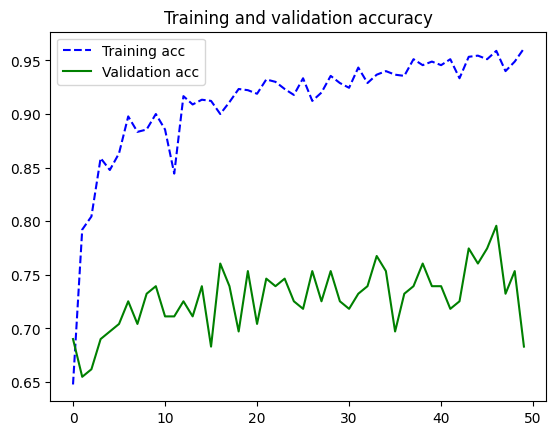

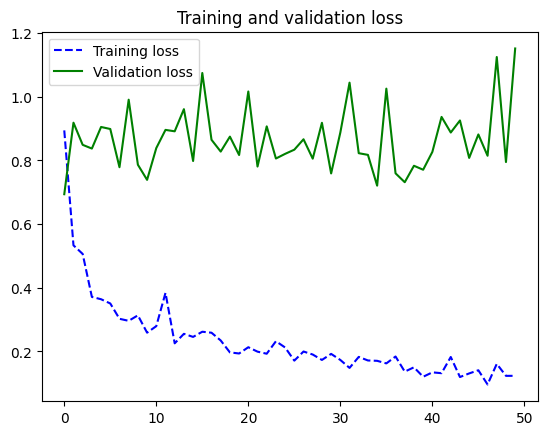

In [ ]:
plot_training_analysis2()

Au même stade c'est mieux qu'avec une taille 128*128. Qui l'eut crû ?

In [ ]:
conv_base2.trainable = True
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 32768)             0         
                                                                 
 dense_24 (Dense)            (None, 256)               8388864   
                                                                 
 dense_25 (Dense)            (None, 3)                 771       
                                                                 
Total params: 23104323 (88.14 MB)
Trainable params: 23104323 (88.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5), # Taux d'apprentissage réduit pour ne pas tout casser, ni risquer le sur-apprentissage !
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_datagen2.flow(x_train2, y_train2, batch_size=10),
                    validation_data=(x_val2, y_val2),
                    epochs=50,
                    )

NameError: name 'model' is not defined